### Dostowanie danych pomiarowych produkcji paneli
* Wczytanie danych z pliku csv
* Podział kolumny zawierającej informacje o dacie na sześć osobnych składowych: rok, miesiąc, minuta, sekunda, data, czas
* Posortowanie danych w kolejności czasowej

In [1]:
%load_ext autoreload
%autoreload 2

In [74]:
import pandas as pd

pv = pd.read_csv('data/100343/example.csv')
pv.head()

DateTime  Moc chwilowa PV
0  2021-01-01 10:11:13            0.001
1  2021-01-01 10:16:13            0.000
2  2021-01-01 10:30:01            0.043
3  2021-01-01 10:36:13            0.000
4  2021-01-01 10:40:01            0.158

In [77]:
from source.PVData import PVData

pv_data = PVData(pv, verbose=True)

print(pv_data.get().head())

Dataset from 2021-01-01 to 2021-12-31
Missing days: [2021-01-10] [2021-01-13] [2021-01-14] [2021-01-15] [2021-01-16] [2021-01-17] [2021-01-19] [2021-01-20] [2021-03-01] [2021-03-02] [2021-03-03] [2021-03-04] [2021-03-05] [2021-03-06] [2021-03-07] [2021-03-08] [2021-03-09] [2021-03-10] [2021-03-11] [2021-03-12] [2021-03-13] [2021-03-14] [2021-03-15] [2021-03-16] [2021-03-17] [2021-03-18] [2021-03-19] [2021-03-20] [2021-03-21] [2021-03-22] [2021-03-23] [2021-03-24] [2021-03-25] [2021-03-26] [2021-03-27] [2021-03-28] [2021-03-29] [2021-03-30] [2021-03-31] [2021-12-24] 
             DateTime  PV_output
0 2021-01-01 10:11:13      0.001
1 2021-01-01 10:16:13      0.000
2 2021-01-01 10:30:01      0.043
3 2021-01-01 10:36:13      0.000
4 2021-01-01 10:40:01      0.158


### Zliczenie liczby próbek na godzinę
Pierwszym aspektem, który należy sprawdzić w badanym zbiorze danych to równomierność rozłożenia próbek odczytu produkcji paneli słonecznych w poszczególnych miesiącach.

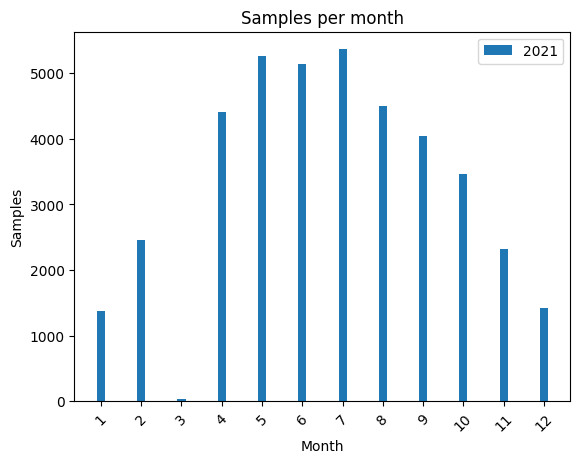

In [78]:
import matplotlib.pyplot as plt
import numpy as np 

per_month = pd.DataFrame(pv_data.get().groupby(['Year', 'Month']).size().reset_index(name='Count'))

x_axis = np.arange(12)

for i, year in enumerate(per_month['Year'].unique()):
    plt.bar(x_axis+(i*0.2), per_month[per_month['Year']==year]['Count'], width=0.2, label = year)

plt.xticks(x_axis, per_month['Month'].unique())
plt.title('Samples per month')
plt.xlabel('Month')
plt.ylabel('Samples')
plt.tick_params(axis='x', labelrotation = 45)
plt.legend()
plt.show()


### Produkcja na dzień

In [91]:
import datetime
first_time = datetime.datetime.now()
later_time = datetime.datetime.now()
difference = later_time - first_time

In [97]:
data = pv_data.get(columns=['Time', 'Date', 'DateTime'])

start_per_day = pd.DataFrame(data.groupby(['Date']).min().reset_index())

end_per_day = pd.DataFrame(data.groupby(['Date']).max().reset_index())

time_diff = end_per_day['DateTime'] - start_per_day['DateTime']

pv_timing = pd.DataFrame({'Date' : start_per_day['Date'], 'Start' : start_per_day['Time'], 'End' : end_per_day['Time'], 'Time': time_diff.dt.total_seconds() / 3600})


Date     Start       End      Time
0  2021-01-01  10:11:13  14:01:13  3.833333
1  2021-01-02  08:51:12  14:35:01  5.730278
2  2021-01-03  08:51:13  14:30:01  5.646667
3  2021-01-04  08:36:13  13:50:00  5.229722
4  2021-01-05  09:41:13  14:10:00  4.479722

In [98]:
per_day = pv_data.get(columns=['PV_output', 'Year', 'Month', 'Day'])

per_day = pd.DataFrame(per_day.groupby(['Year', 'Month', 'Day']).mean().reset_index())

per_day['Time'] = pv_timing['Time']

per_day['Output'] = pv_timing['Time'] * per_day['PV_output']

per_day.head()

Year  Month  Day  PV_output      Time    Output
0  2021      1    1   0.090867  3.833333  0.348322
1  2021      1    2   0.187100  5.730278  1.072135
2  2021      1    3   0.295275  5.646667  1.667322
3  2021      1    4   0.134932  5.229722  0.705658
4  2021      1    5   0.115396  4.479722  0.516943

### Produkcja na godzinę

In [102]:
data = pv_data.get(columns=['Year', 'Month', 'Hour', 'Day', 'PV_output'])

pv_per_hour = pd.DataFrame(data.groupby(['Year', 'Month', 'Day', 'Hour']).mean().reset_index())

pv_per_hour.head()

Year  Month  Day  Hour  PV_output
0  2021      1    1    10   0.058000
1  2021      1    1    11   0.111417
2  2021      1    1    12   0.098917
3  2021      1    1    13   0.091750
4  2021      1    1    14   0.000000

In [108]:
import calendar

months = pd.DataFrame(pv_data.get(columns=['Year', 'Month']).groupby(['Year', 'Month']).sum().reset_index())

month_names = dict((i, month_name) for i, month_name in enumerate(calendar.month_name) if i != 0)

nmb_of_rows = int(months.shape[0])
max_value = per_day['Output'].max()

plt.figure(figsize=(30,300))

for index, row in months.iterrows():
    month, year = row['Month'], row['Year']

    month_samples =  per_day[(per_day['Year'] == year) & (per_day['Month'] == month)]
    
    plt.subplot(nmb_of_rows, 2, (2 * index) + 1)
    plt.bar(month_samples['Day'], month_samples['Output'])
    plt.ylim(0, 1.1 * max_value)
    plt.title(f"{month_names[(index % 12) + 1]} ({year})")
    plt.xlabel('Day')
    plt.ylabel('Energy [kWh]')

    plt.subplot(nmb_of_rows, 2, (2 * index) + 2)
    for day in month_samples['Day']:
        day_samples =  pv_per_hour[(pv_per_hour['Year'] == year) & (pv_per_hour['Month'] == month) & (pv_per_hour['Day'] == day)]

        if(len(day_samples) > 0):
            plt.plot(day_samples['Hour'].astype('int'), day_samples['PV_output'])


### Produkcja miesięczna


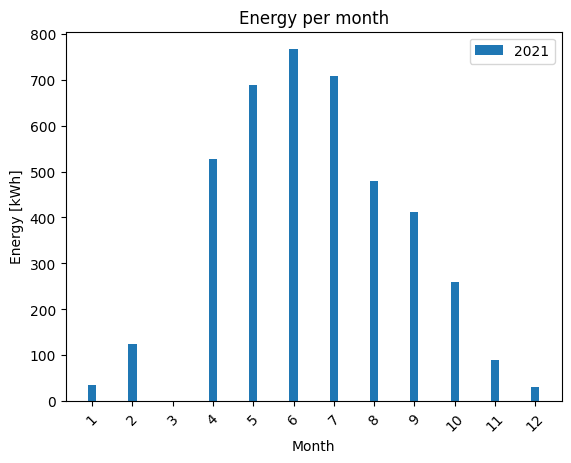

In [112]:
per_month = pd.DataFrame(per_day[['Year', 'Month', 'Time', 'Output']].groupby(['Year', 'Month']).sum().reset_index())

per_month['Date'] = per_month.apply(lambda row: f"{row['Year']}-{row['Month']}", axis=1)

x_axis = np.arange(12)

for i, year in enumerate(per_month['Year'].unique()):
    plt.bar(x_axis+(i*0.2), per_month[per_month['Year']==year]['Output'], width=0.2, label = year)


plt.xticks(x_axis, per_month['Month'].unique())
plt.title('Energy per month')
plt.xlabel('Month')
plt.ylabel('Energy [kWh]')
plt.tick_params(axis='x', labelrotation = 45)
plt.legend()
plt.show()

### Wczytanie danych pogodowych

|Atrybut|Opis|Zakres|
|-|-|-|
|PeriodEnd|Koniec okresu pomiarowego|-|
|PeriodStart|Początek okresu pomiarowego|-|
|AirTemp|Temperatura powietrza 2 metry powyżej gruntu|-|
|Azimuth|Kąt azymutu słonecznego|Od -180 do 180|
|CloudOpacity|Tłumienie wpadającego światła słonecznego z powodu zachmurzenia|0(brak chmur)-100(pełne tłumienie)|
|DewpointTemp|Temperatura punktu rosy 2 metry nad poziomem gruntu|-|
|DHI|(Direct Horizontal Irradiance) Rozproszone natężenie promieniowania padające na poziomą powierzchnię|-|
|DNI|(Direct Normal Irradiance) Rozproszone natężenie promieniowania padające na poziomą powierzchnię|-|
|Ebh|Bezpośrednie natężenie promieniowania (dochodzące w linii prostej od słońca) otrzymane na poziomej powierzchni|-|
|GHI|(Global Horizontal Irradiance) Całkowite natężenie promieniowania padającego na poziomą powierzchnię. Jest to suma bezpośrednich i rozproszonych składowych promieniowania padającego na poziomą powierzchnię|-|
|PrecipitableWater|Woda opadowa całej kolumny atmosferycznej|-|
|RelativeHumidity|Wilgotność względna powietrza 2 metry nad poziomem gruntu|-|
|SnowWater|Miara fizycznej pokrywy śnieżnej na ziemi, mierzona w centymetrach.|-|
|SurfacePressure|Ciśnienie powietrza na poziomie gruntu|-|
|WindDirection10m|Kierunek wiatru na wysokości 10 metrów nad poziomem gruntu|0(północ)-270(zachód)|
|WindSpeed10m|Prędkość wiatru 10 metrów nad poziomem gruntu|-|
|Zenith|Kąt między linią prostopadłą do powierzchni ziemi a słońcem|0(słońce nad głową)
|AlbedoDaily|Średni dzienny współczynnik odbicia światła widzialnego od powierzchni|0(pełna absorpcja)-1(pełne odbicie)|
|Gti|Całkowite natężenie promieniowania padające na powierzchnię o określonym nachyleniu|



### Bibliografia
* https://pvmonitor.pl//i_user.php?idinst=100343&od=2022-01-02&do=2022-01-02#/sumapv
* https://www.kaggle.com/code/pythonafroz/solar-power-generation-forecast-with-99-auc/notebook